# 2. MUSICAL TEMPO CLASSIFICATION

High-level steps:

1. Create train, validation and test sets
2. Build the neural network
3. Train the neural network
4. Evaluate the neural network on the test set
5. Make predictions on a new sample

In [169]:
import import_ipynb
N = import_ipynb.NotebookLoader(path=['.'])
N.load_module("Functions")
from Functions import *

importing Jupyter notebook from .\Functions.ipynb


# Important values

In [188]:
# Paths to the data:
annotations_folder = 'storage/annotationsForMusicalTempoClassification'
audio_folder = 'storage/audioForMusicalTempoClassification'
spectrograms_storage_file_name = 'storage/musicalTempoClassificationSpectrograms.npy'
melspectrograms_storage_file_name = 'storage/musicalTempoClassificationMelspectrograms.npy'
num_classes = None # Assigned later
segments_per_file = 20

# Obtain data

## Mapping between musical keys & integers
This is for creating target values amenable to 1-hot encoding, which in turn helps in training...

To solve tempo recognition as a classification problem, we consider integer values of tempo classes from [0, 5) to [250, 255).

Reading from the annotations folder...

> REFERENCE: https://www.geeksforgeeks.org/how-to-read-from-a-file-in-python/

In [189]:
# Navigate to the annotations directory:
os.chdir(annotations_folder)
  
# Functions for reading text files:
tracks, annotations = [], []
def read_text_file(file_path): 
    with open(file_path, 'r') as f:
        tracks.append(file_path[:-9]) # The slicing of `file_path` excludes the file extensions and keeps the track ID
        annotations.append(float(f.read()))
        f.close()
  
# Iterate through all files in the current directory: 
for file in os.listdir():
    file_path = f'{file}'
    read_text_file(file_path)

# Navigating back to the previous folder:
os.chdir('..')

Obtaining tempo annotations as integer classes...

In [190]:
num_classes = 50

annotations_by_classes = []
for annotation in annotations:
    annotations_by_classes.append(int(annotation // 5))

## Ground truth

Creating a dataframe for the ground truth...

In [191]:
# Creating the dataframe
df = pd.DataFrame(data={'TRACK':tracks, 'TEMPO':annotations, 'TARGET':annotations_by_classes})
# Seeing some rows of the dataset:
df.head(5)

,TRACK,TEMPO,TARGET
0,1030011,127.0,25
1,1068430,174.0,34
2,1084996,142.0,28
3,1092771,136.0,27
4,1114156,86.0,17


# Preparing datasets

Obtaining melspectrograms for each audio file...

In [207]:
audio_params, data = get_all_melspectrograms(df,
                                             audio_folder,
                                             spectrograms_storage_file_name,
                                             melspectrograms_storage_file_name,
                                             segments_per_file=segments_per_file,
                                             n_mels=12)

Regenerate spectrograms? No
Regenerate melspectrograms? Yes


...........
Done


In [208]:
for key in audio_params: print(f'{key}: {audio_params[key]}')

segments_per_file: 20
sr: 44100
n_fft: 2048
hop_length: 512
n_mels: 12
n_frames: 2000


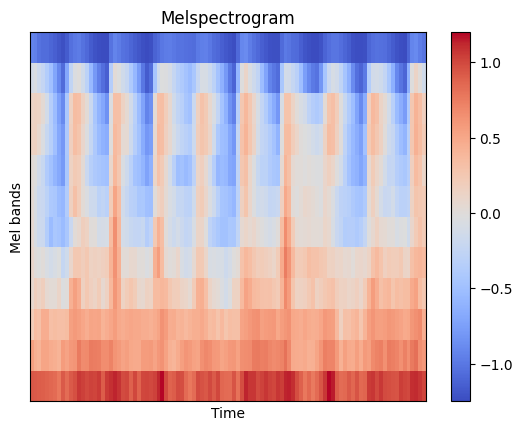

In [209]:
get_random_melspectrogram(data)

Now, note that for RNN training, we need to ensure that each data point (i.e. each spectrogram array) is in the form:

`<time steps, features>`

Hence, for each data point, the first dimension must be the time stamps and the second dimension must be the mel bands.

Taking a look at our `data` variable...

In [210]:
print(np.array(data).shape)

(13280, 12, 100)


We see that the order is reverse from what it should be. Hence, we do the following...

In [211]:
transposed_data = []
for d in data:
    transposed_data.append(np.transpose(d))

Confirming the new shape...

In [212]:
print(np.array(transposed_data).shape)

(13280, 100, 12)


Obtaining the data to be used for training and testing of neural networks...

In [213]:
data_params, data_and_labels, train_dataset, validation_dataset = get_data(df,
                                                                           transposed_data,
                                                                           num_classes,
                                                                           segments_per_file=segments_per_file,
                                                                           validation_start=0.9,
                                                                           batch_size=64)

Training data shape = (11952, 100, 12), Validation data shape = (1328, 100, 12)


In [214]:
for key in data_params: print(f'{key}: {data_params[key]}')

segments_per_file: 20
validation_start: 0.9
num_classes: 50
batch_size: 64


# Building & training the RNN

> REFERENCES:
> - https://www.tensorflow.org/guide/keras/working_with_rnns
> - https://keras.io/api/layers/recurrent_layers/bidirectional/
> - https://blog.paperspace.com/bidirectional-rnn-keras/
> - https://keras.io/api/layers/recurrent_layers/stacked_rnn_cell/
> - https://keras.io/api/layers/recurrent_layers/simple_rnn_cell/
> - https://youtu.be/4nXI0h2sq2I?si=qT4aDoM9UojjhQr6
> - https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/

In [215]:
rnn_out = 64

# Function to generate RNN model...
def get_model(input_shape=(audio_params['n_frames'] // data_params['segments_per_file'], audio_params['n_mels'])):
    # NOTE: Input shape should be in the form <time steps, features>
    '''
    Input parameters:
    - `input_shape (tuple)`: Shape of input set

    Return values:
    - `model`: B-RNN model
    '''

    # BUILD MODEL TOPOLOGY
    
    model = keras.Sequential()
    model.add(keras.layers.Input(input_shape))

    # Stacked RNN layers:
    rnn_cells = [keras.layers.SimpleRNNCell(rnn_out, activation='tanh', dropout=0, recurrent_dropout=0.05) for _ in range(3)]
    model.add(keras.layers.Bidirectional(keras.layers.RNN(keras.layers.StackedRNNCells(rnn_cells))))

    # Average pooling layer:
    keras.layers.AveragePooling2D(pool_size=(5, 1))

    # Fully-connected layers with batch normalisation:
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(64, activation='elu'))
    keras.layers.Dropout(0.5),
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(64, activation='elu'))
    keras.layers.Dropout(0.5),
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    #------------------------------------
    # COMPILING MODEL WITH APPROPRIATE LOSS AND OPTIMIZER

    # Optimizer:
    optimizer = keras.optimizers.SGD(learning_rate=0.01)
    # Loss function:
    loss = keras.losses.CategoricalCrossentropy()
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'])

    return model

Checking the model's architecture...

In [216]:
model = get_model()
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_35 (Bidirectional)     │ (None, 128)                 │          42,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_105              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_106              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_107              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 50)                  │           3,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,570 (232.70 KB)

 Trainable params: 59,058 (230.70 KB)

 Non-trainable params: 512 (2.00 KB)

**NOTES**:

**Stacked RNN cell layer**:

`keras.layers.StackedRNNCells(cells, **kwargs)`

Wrapper allowing a stack of RNN cells to behave as a single cell.

## Defining customised performance function
Customised performance function to account for distance from correct label...

Given the following:

- $y_i$ = $i$-th true target value
- $\hat{y}_i$ = $i$-th predicted target value
- $n$ = Number of predictions

Calculation of performance is done as follows:

- Obtain of $r_i = \min(\frac{\hat{y}_i + 1}{y_i + 1}$ and $\frac{y_i + 1}{\hat{y}_i + 1})$ <br> _1 is added to prevent 0-division_
- Obtain $R = \sum r_i$
- Obtain performance as $\frac{R}{n}$

**NOTE: Nature of performance value**:

- The highest possible performance is 1
- The lowest possible performance is non-zero but close to zero
- The same difference between $\hat{y}_i$ and $y_i$ is penalised less if $\hat{y}_i > y_i$ <br> _This is because the higher tempi, the lesser the proportional difference between the two tempi_

In [217]:
def get_performance(model, data, labels, return_differences=False):
    n = float(len(data))

    predictions = np.argmax(model(data), axis=1)
    # NOTE: `model.predict(x)` returns a vector whose maximum value's index corresponds to the predicted target value

    total = 0;
    differences = []
    
    for y_pred, y_true in zip(predictions, labels):
        ratio = min(float(y_pred + 1) / (y_true + 1), float(y_true + 1) / (y_pred + 1))
        total += ratio
        differences.append(abs(y_pred - y_true))
    
    if return_differences:
        return total/n, differences
    return total/n

## Training the B-RNN
### APPROACH 1: Use of predefined training functions (for demonstration purposes)
Using predefined methods of `tensorflow.keras.Model`.

> REFERENCES:
> - https://victorzhou.com/blog/keras-cnn-tutorial/
> - https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [218]:
# Code needed to log training history:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('musicalTempoClassificationTraining.log', separator=',', append=False)

# Building model:
model = get_model()

# Training model:
print('TRAINING')
history = model.fit(
    train_dataset,
    epochs=60,
    batch_size=data_params['batch_size'],
    validation_data=validation_dataset,
    verbose=True,
    callbacks=[csv_logger])

TRAINING
Epoch 1/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.1767 - loss: 3.8003 - val_accuracy: 0.3133 - val_loss: 3.2157
Epoch 2/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.3185 - loss: 3.1516 - val_accuracy: 0.3065 - val_loss: 3.0709
Epoch 3/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.3311 - loss: 2.8759 - val_accuracy: 0.3102 - val_loss: 2.8397
Epoch 4/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.3425 - loss: 2.6475 - val_accuracy: 0.3185 - val_loss: 2.6444
Epoch 5/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.3537 - loss: 2.4844 - val_accuracy: 0.3238 - val_loss: 2.5470
Epoch 6/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.3628 - loss: 2.3740 - val_accuracy: 0.3291 - val_loss: 2.4389
Epoch 7/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.3814 - loss: 2.2871 - val_accuracy: 0.3652 - val_loss: 2.3447
Epoch 8/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.4132 - loss: 

In [219]:
# Evaluating model:
print('\nEVALUATION')
validation_error, validation_accuracy = model.evaluate(validation_dataset, verbose=True)
performance = get_performance(model, data_and_labels['validation_data'], data_and_labels['validation_labels'], return_differences=True)
print('Validation performance =', performance[0])


EVALUATION
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6430 - loss: 1.2731
Validation performance = 0.9226064322889601


Mean and standard deviation of differences between true and predicted tempi...

In [220]:
print(f'Mean: {np.mean(performance[1])}\nStd: {np.std(performance[1])}')

Mean: 2.4631024096385543
Std: 5.268269418339485


In [221]:
# Saving the model for later use:
save_model(model, 'storage/musicalTempoClassificationTrainedModelWeights.npy')

Plotting the model's accuracy (training and validation) across training...

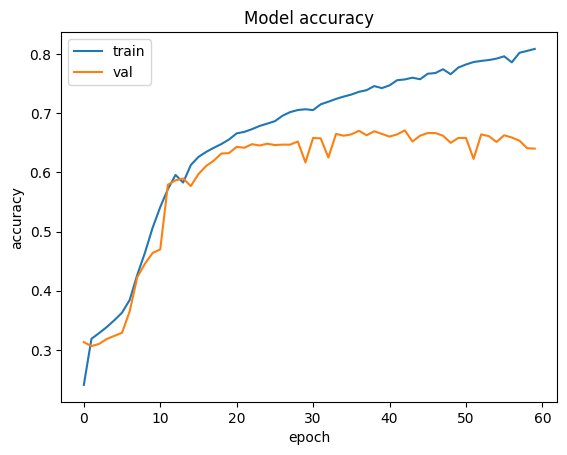

In [222]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()